<a href="https://colab.research.google.com/github/DimaKav/DS-Unit-1-Sprint-4-Statistical-Tests-and-Experiments/blob/master/module2-sampling-confidence-intervals-and-hypothesis-testing/LS_DS_142_Sampling_Confidence_Intervals_and_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [0]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [0]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=38.69323106073592, pvalue=3.961609200867749e-09)


In [0]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## Live Lecture - let's explore some more of scipy.stats

In [0]:
# Playing with distributions

from scipy.stats import chi2

chi2_5 = chi2(5)
chi2_5

In [0]:
chi2_5.mean()

5.0

In [0]:
chi2_5.median()

4.351460191095526

In [0]:
chi2_500 = chi2(500)
print(chi2_500.mean(), chi2_500.median())

500.0 499.3334915888738


In [0]:
dir(chi2_5.pdf)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [0]:
# Test how normal a chisquare(500) is
from scipy.stats import normaltest

normaltest(chi2_500.rvs(100000))

NormaltestResult(statistic=283.7729586883694, pvalue=2.395989795920015e-62)

In [0]:
help(normaltest)

Help on function normaltest in module scipy.stats.stats:

normaltest(a, axis=0, nan_policy='propagate')
    Test whether a sample differs from a normal distribution.
    
    This function tests the null hypothesis that a sample comes
    from a normal distribution.  It is based on D'Agostino and
    Pearson's [1]_, [2]_ test that combines skew and kurtosis to
    produce an omnibus test of normality.
    
    
    Parameters
    ----------
    a : array_like
        The array containing the sample to be tested.
    axis : int or None, optional
        Axis along which to compute test. Default is 0. If None,
        compute over the whole array `a`.
    nan_policy : {'propagate', 'raise', 'omit'}, optional
        Defines how to handle when input contains nan. 'propagate' returns nan,
        'raise' throws an error, 'omit' performs the calculations ignoring nan
        values. Default is 'propagate'.
    
    Returns
    -------
    statistic : float or array
        ``s^2 + k^2``, wh

In [0]:
# One way chi-square test

from scipy.stats import chisquare

chi_data = [[1, 2], [2, 1]]
chisquare(chi_data, axis=None)

Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)

In [0]:
from scipy import stats
help(stats.t.ppf)

Help on method ppf in module scipy.stats._distn_infrastructure:

ppf(q, *args, **kwds) method of scipy.stats._continuous_distns.t_gen instance
    Percent point function (inverse of `cdf`) at q of the given RV.
    
    Parameters
    ----------
    q : array_like
        lower tail probability
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information)
    loc : array_like, optional
        location parameter (default=0)
    scale : array_like, optional
        scale parameter (default=1)
    
    Returns
    -------
    x : array_like
        quantile corresponding to the lower tail probability q.



In [0]:
# Confidence intervals
# Similar to hypothesis testing, but centered at sample mean
# Generally better than reporting the 'point estimate' (sample mean)
# ...point estimates aren't always perfect

import numpy as np
from scipy import stats

def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2., n - 1)
  return (mean, mean - interval, mean + interval)

def report_confidence_interval(confidence_interval):
  """
  Return a string with a pretty report of a confidence interval.
  
  Arguments:
    confidence_interval - tuple of (mean, lower bound, upper bound)
  
  Returns:
    None, but prints to screen the report
  """
  #print('Mean: {}'.format(confidence_interval[0]))
  #print('Lower bound: {}'.format(confidence_interval[1]))
  #print('Upper bound: {}'.format(confidence_interval[2]))
  s = "our mean lies in the interval [{:.2}, {:.2}]".format(
      confidence_interval[1], confidence_interval[2])
  return s

In [3]:
x = 2
print('x is: {}'.format(x))

x is: 2


In [4]:
coinflips = np.random.binomial(n=1, p=0.7, size=100)
print(coinflips)

[1 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1 0
 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1
 1 1 1 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1]


In [5]:
stats.ttest_1samp(coinflips, 0.5)

Ttest_1sampResult(statistic=3.12909072914302, pvalue=0.0023039657126900713)

In [7]:
import pandas as pd
df = pd.DataFrame(coinflips)
df.describe()

,0
count,100.000000
mean,0.650000
std,0.479372
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [8]:
coinflip_interval = confidence_interval(coinflips)  # Default 95% conf
coinflip_interval

(0.65, 0.5548820988300915, 0.7451179011699085)

In [9]:
report_confidence_interval(coinflip_interval)

'our mean lies in the interval [0.55, 0.75]'

In [10]:
help(confidence_interval)

Help on function confidence_interval in module __main__:

confidence_interval(data, confidence=0.95)
    Calculate a confidence interval around a sample mean for given data.
    Using t-distribution and two-tailed test, default 95% confidence. 
    
    Arguments:
      data - iterable (list or numpy array) of sample observations
      confidence - level of confidence for the interval
    
    Returns:
      tuple of (mean, lower bound, upper bound)



## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.

In [0]:
# Process data

import numpy as np
import pandas as pd
import scipy

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data',
                 header=None)

# Change column names to correspond to attributes

columns = [
'party',
'infants',
'water-project',
'budget-resolution',
'physician-fee',
'el-salvador',
'religion-in-school',
'anti-satellite-test-ban',
'aid-to-nicaragua',
'mx-missile',
'immigration',
'synfuelscorp-cutback',
'education-spending',
'superfund-right-to-sue',
'crime',
'duty-free-exports',
'expadmin-act-south-africa'
]

df.columns = columns

# Replace y with 1 and n with 0

df = df.replace(to_replace=dict(y=1, n=0))

# Change ? to nan

df = df.replace('?', np.NaN)

reps = df[df['party'] == 'republican'].drop(['party'], axis=1)
dems = df[df['party'] == 'democrat'].drop(['party'], axis=1)

## Confidence intervals for above data

In [64]:
# Compute confidence intervals for the issues of each party in a tuple where
# the 1st number is the mean, the 2nd is the lower bound, and 3rd is upper bound

print('Confidence intervals for democratic issues:\n')
for d in dems:
  print(d, confidence_interval(dems[d].dropna()))
  
print('\n' + 'Confidence intervals for republican issues:\n')
for r in reps:
  print(r, confidence_interval(reps[r].dropna()))

Confidence intervals for democratic issues:

infants (0.6046511627906976, 0.5445926997425515, 0.6647096258388437)
water-project (0.502092050209205, 0.43824514095228484, 0.5659389594661252)
budget-resolution (0.8884615384615384, 0.8499435153340716, 0.9269795615890052)
physician-fee (0.05405405405405406, 0.02633186149720885, 0.08177624661089927)
el-salvador (0.21568627450980393, 0.1648631139997972, 0.26650943501981067)
religion-in-school (0.47674418604651164, 0.41539182663748236, 0.5380965454555409)
anti-satellite-test-ban (0.7722007722007722, 0.7207820216365644, 0.8236195227649801)
aid-to-nicaragua (0.8288973384030418, 0.7830845214499412, 0.8747101553561424)
mx-missile (0.7580645161290323, 0.7043940111605527, 0.8117350210975118)
immigration (0.4714828897338403, 0.41075744059137587, 0.5322083388763047)
synfuelscorp-cutback (0.5058823529411764, 0.4441027014712158, 0.5676620044111371)
education-spending (0.14457831325301204, 0.10059494022327561, 0.18856168628274847)
superfund-right-to-sue 

**Observations & interpretation**:
1. The confidence intervals are centered around the means which implies that I performed the calculations correctly.
2. It's important to take note of the wide-range of possibilites for some of the issues, this will be more apparent in a visualization.
3. The intervals imply that if we repeated this experiment n times, the average result would be in the interval 95% of the time.


## Visualizing the confidence intervals with a plot

In [0]:
import matplotlib.pyplot as plt

True means show us that there was a slight bias towards voting 'yes' in general.

 True means for: 

 Republicans: 0.5202842153559786 Democrats: 0.5272036172051707 




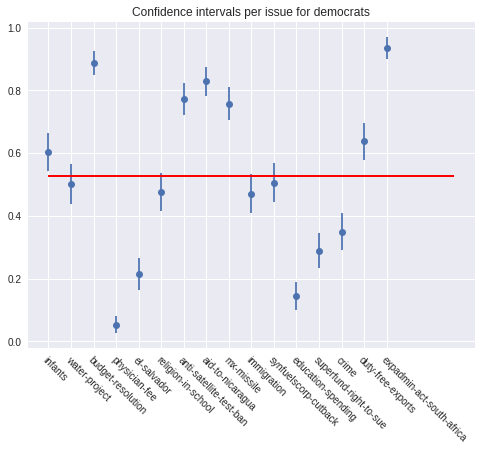

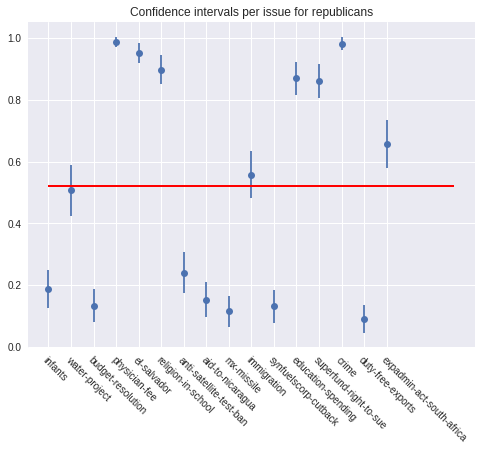

In [99]:
true_meand = dems.mean().mean()
true_meanr = reps.mean().mean()
intervals_d = [confidence_interval(dems[d].dropna())[1:] for d in dems]
intervals_r = [confidence_interval(reps[r].dropna())[1:] for r in reps]

print("True means show us that there was a slight bias towards voting 'yes' in general.")
print('\n True means for: \n\n Republicans:', true_meanr, 'Democrats:', true_meand, '\n\n')
# Democrat plot of confidence intervals with red line being the mean of all the data
# the true means tells us that there was a slight bias toward a voting yes

plt.figure(figsize=(8,6))

plt.errorbar(x=dems.columns, 
             y=dems.mean(), 
             yerr=[(top-bot)/2 for top,bot in intervals_d],
             fmt='o')

plt.hlines(xmin=0, xmax=18,
           y=true_meand, 
           linewidth=2.0,
           color="red")

plt.title('Confidence intervals per issue for democrats')
plt.xticks(rotation=-45, ha="left", rotation_mode="anchor");

# Republican plot of confidence intervals with red line being true mean
# the true means tells us that there was a slight bias toward a voting yes

plt.figure(figsize=(8,6))

plt.errorbar(x=reps.columns, 
             y=reps.mean(), 
             yerr=[(top-bot)/2 for top,bot in intervals_r],
             fmt='o')

plt.hlines(xmin=0, xmax=18,
           y=true_meanr, 
           linewidth=2.0,
           color="red")

plt.title('Confidence intervals per issue for republicans')
plt.xticks(rotation=-45, ha="left", rotation_mode="anchor");